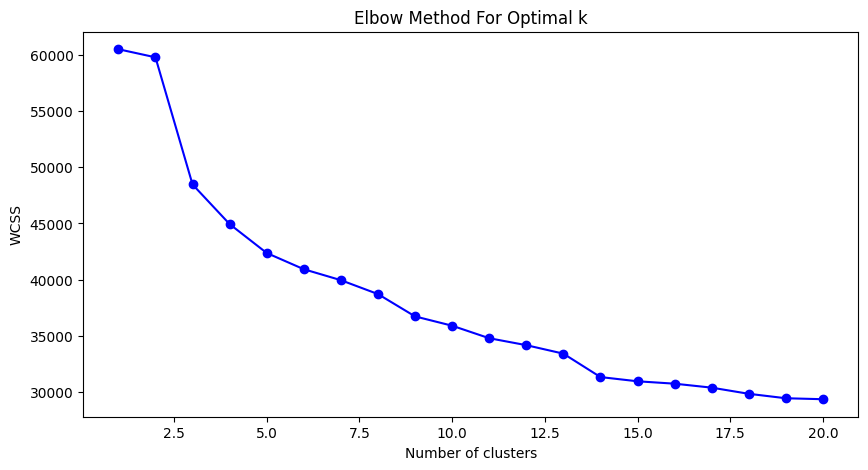

Optimal number of clusters: 20
Number of components explaining 90.0% variance: 20


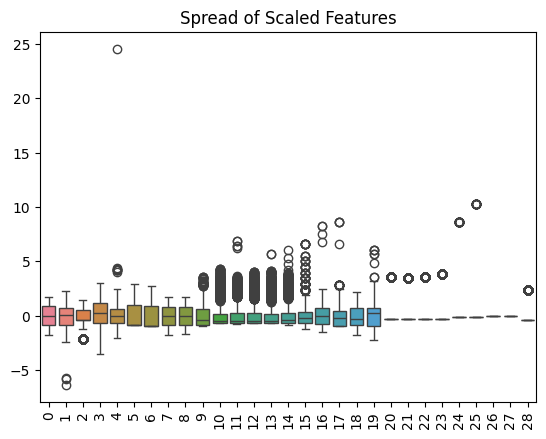

For n_clusters = 20 The average silhouette_score is : 0.07794136491523666


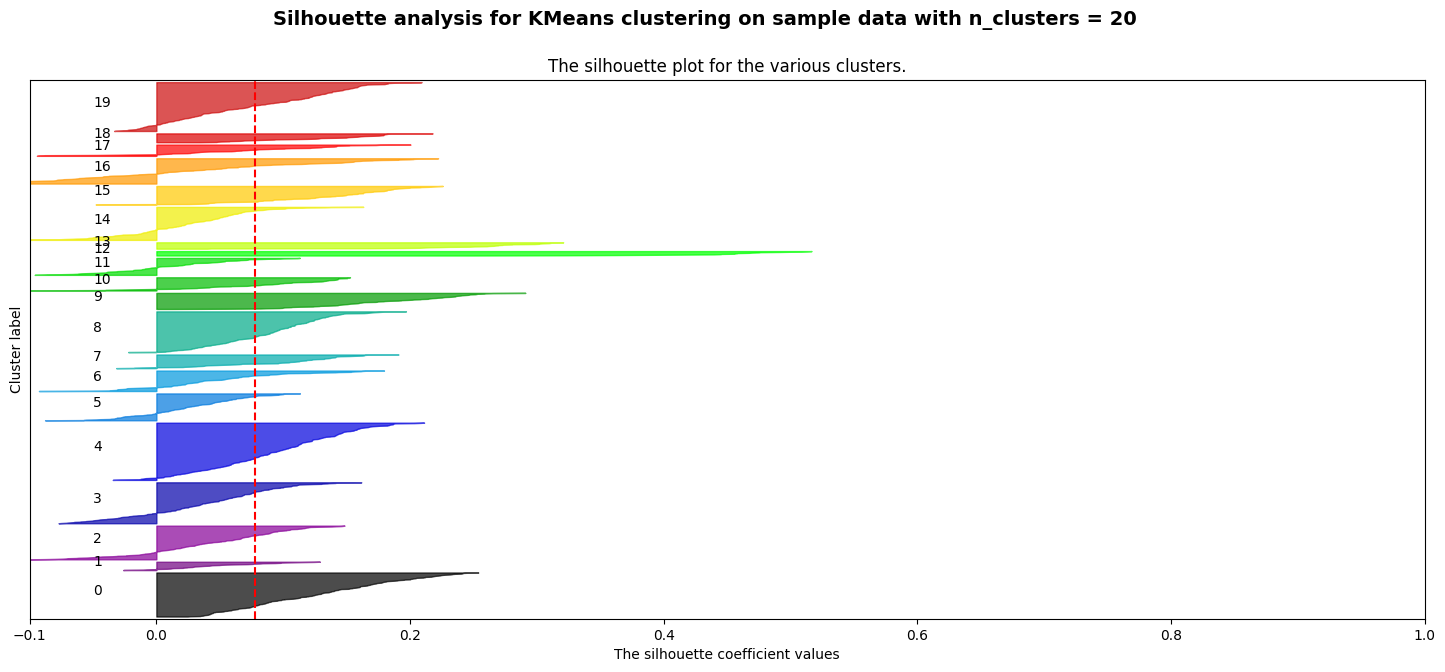

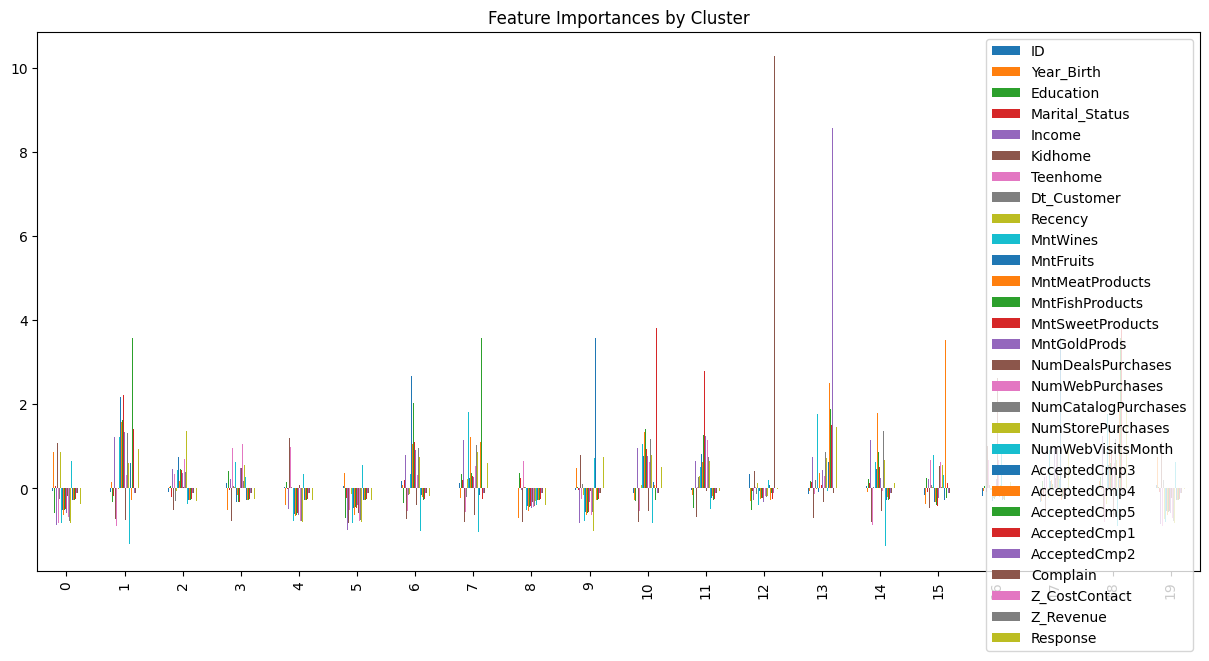

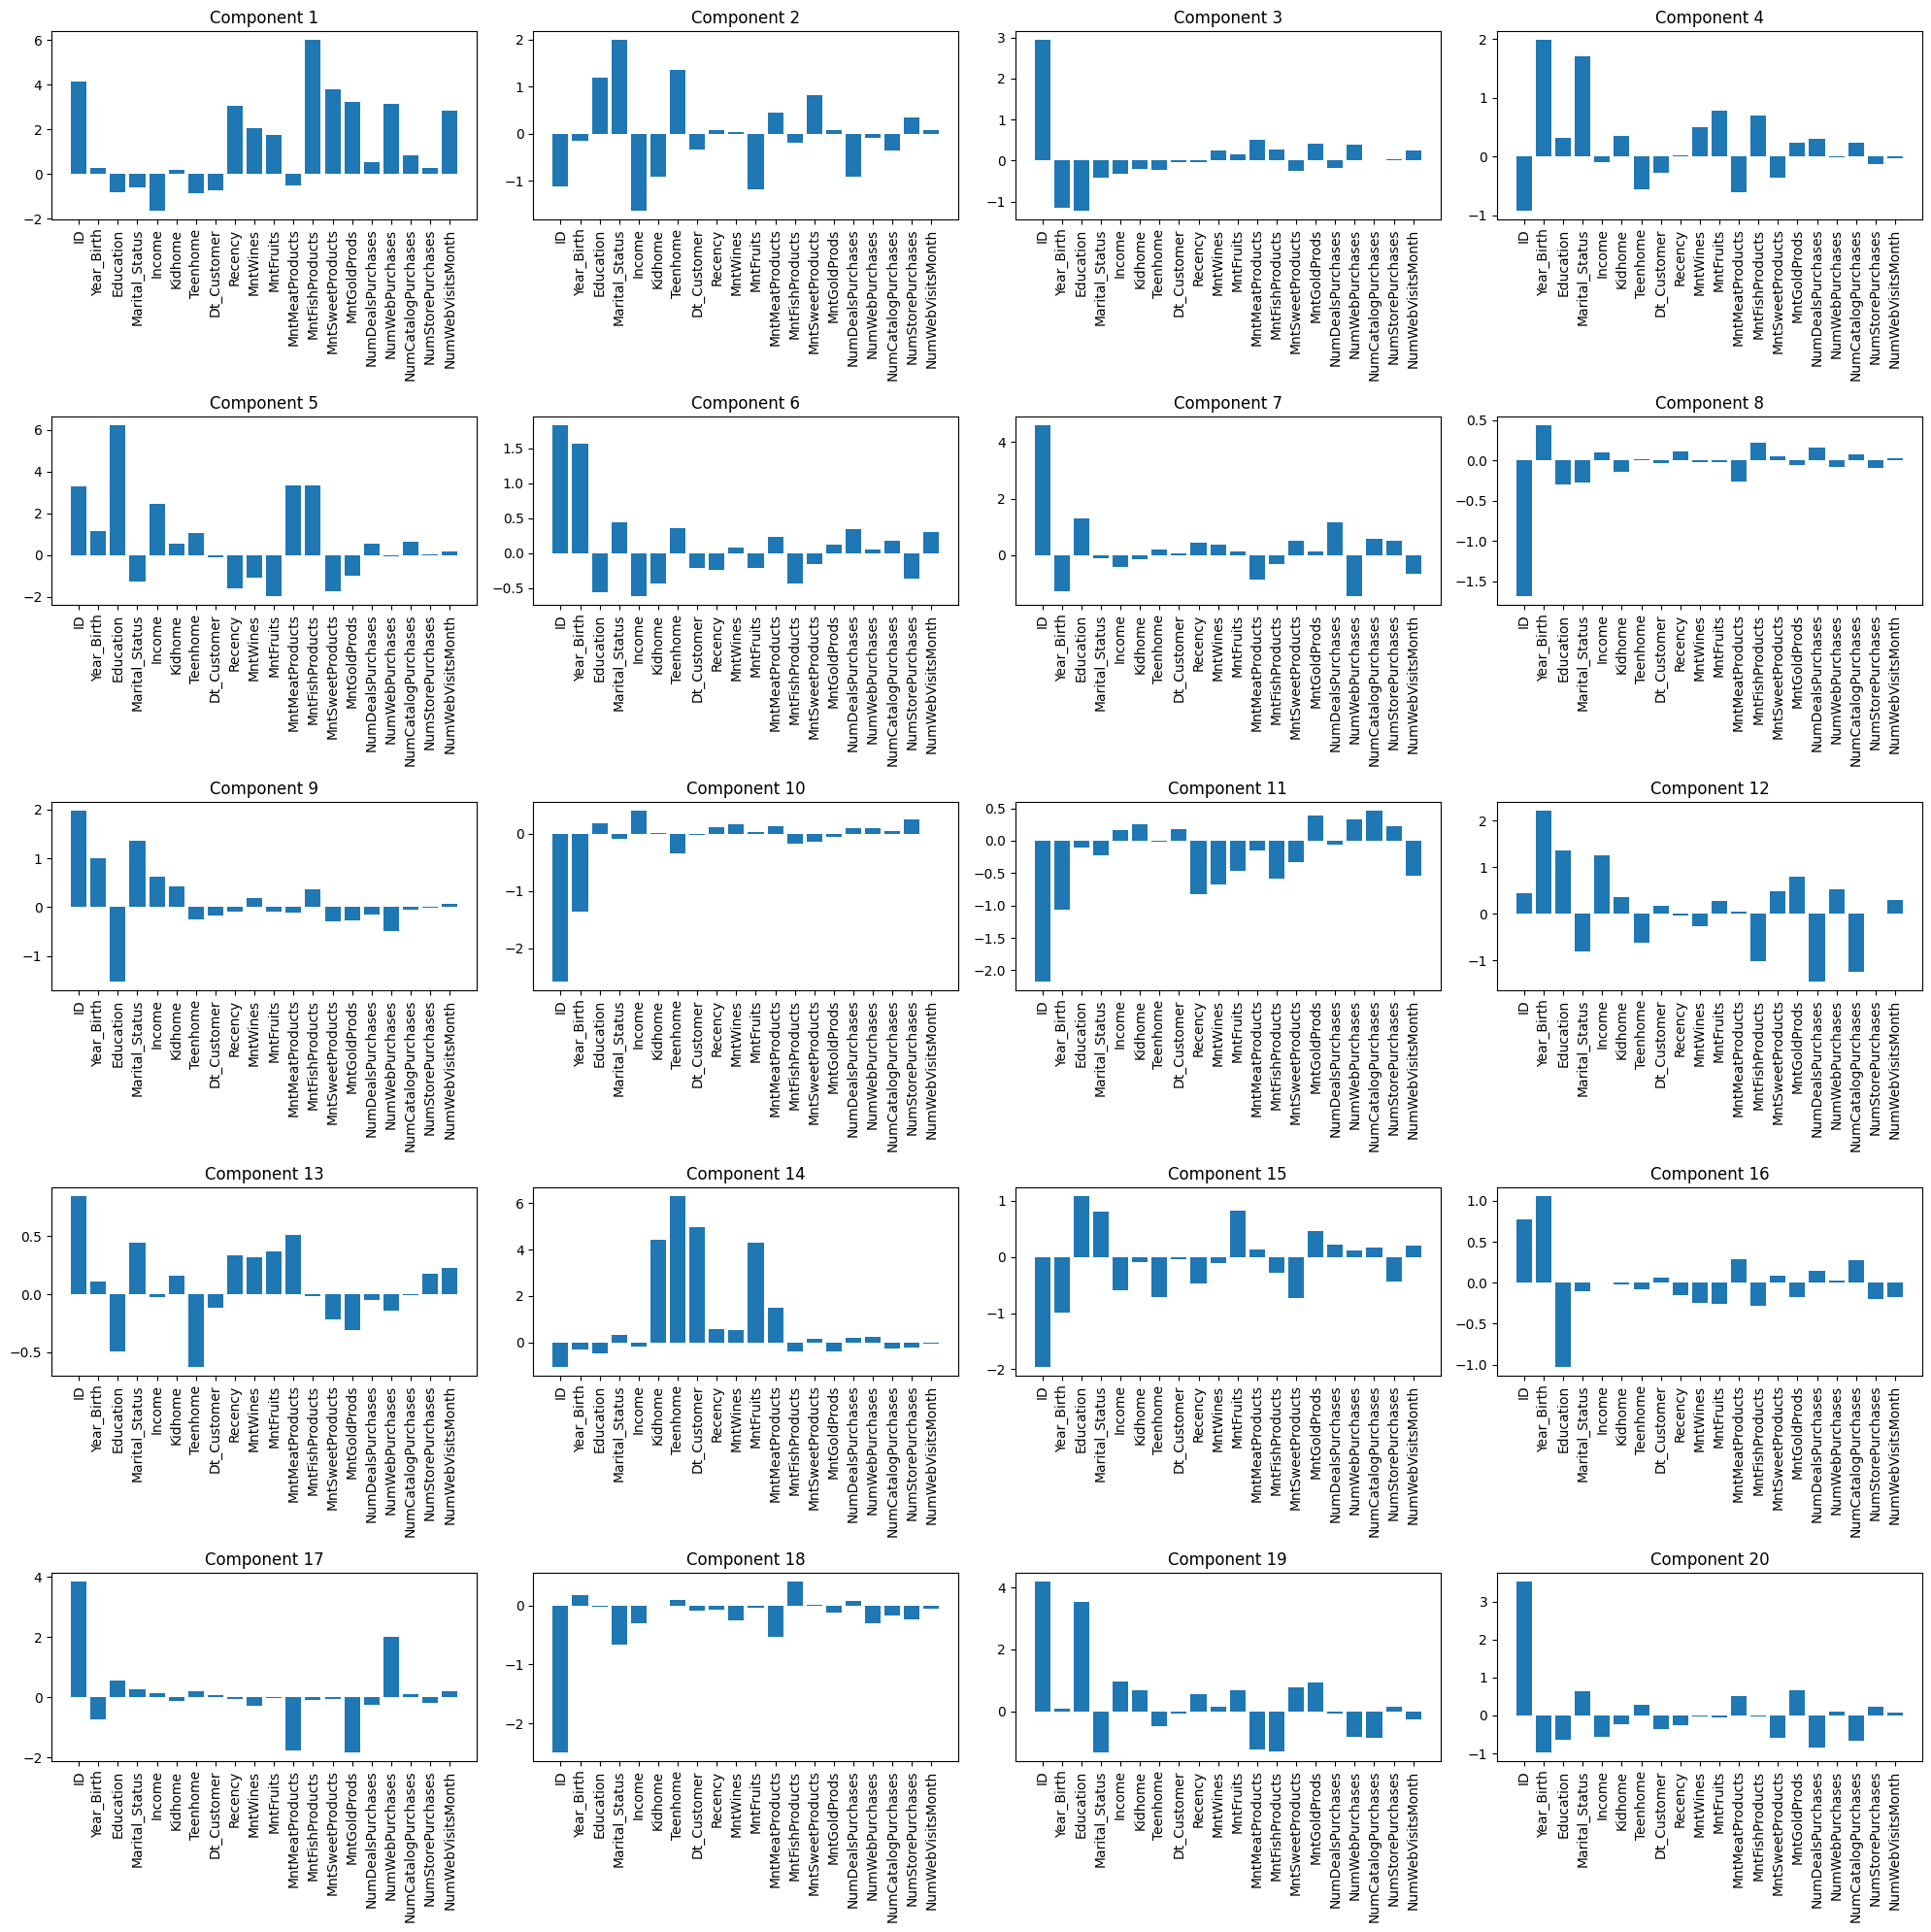

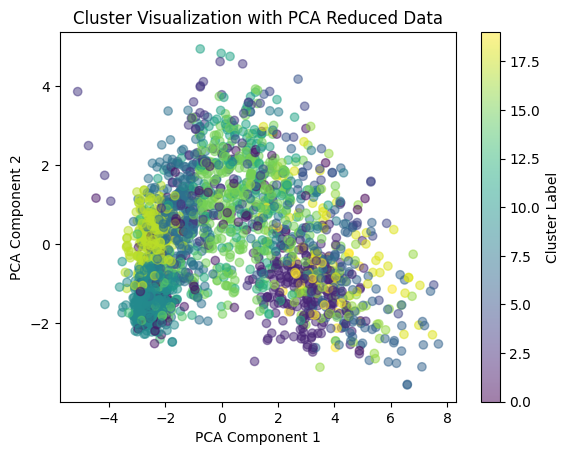

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Setting random seed for reproducibility
np.random.seed(0)

# Load and preprocess data
def load_and_preprocess_customer_data(filepath):
    customer_data = pd.read_csv(filepath)
    customer_data['Income'].fillna(customer_data['Income'].median(), inplace=True)

    label_encoders = {}
    for col in customer_data.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        customer_data[col] = le.fit_transform(customer_data[col])
        label_encoders[col] = le

    return customer_data, label_encoders

# Scale features for clustering
def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaler, scaled_data

# Determine the optimal number of clusters using the elbow method
def plot_elbow_method(data, max_k=10):
    wcss = [] # within-cluster sum of squares
    for k in range(1, max_k + 1): # run KMeans on various cluster sizes
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_k + 1), wcss, 'bo-')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return wcss

# Finds the point where the elbow shape becomes visible
def find_optimal_k(wcss):
    differences = np.diff(wcss)
    differences = np.abs(differences)
    optimal_k = np.argmin(differences) + 2  # +2 for the proper cluster number
    return optimal_k

# Apply PCA to reduce dimensions while retaining 90% of the variance
def pca_analysis(data, variance_ratio=0.90):
    pca = PCA(n_components=variance_ratio)
    pca_data = pca.fit_transform(data)
    print(f"Number of components explaining {variance_ratio*100}% variance: {pca.n_components_}")
    return pca, pca_data

# Clustering using Gaussian Mixture Model
def gaussian_mixture_clustering(data, n_components):
    gm = GaussianMixture(n_components=n_components, random_state=0)
    gm.fit(data)
    labels = gm.predict(data)
    return gm, labels

# Plotting the spread of data after preprocessing
def plot_data_spread(data):
    sns.boxplot(data=pd.DataFrame(data))
    plt.xticks(rotation=90)
    plt.title('Spread of Scaled Features')
    plt.show()

# Plotting the feature importances based on KMeans centroids
def plot_feature_importances(centroids, features):
    feature_importances = pd.DataFrame(centroids, columns=features)
    feature_importances.plot(kind='bar', figsize=(15, 7))
    plt.title('Feature Importances by Cluster')
    plt.show()

# Function to plot silhouette analysis
def silhouette_analysis(data, labels, n_clusters):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # Inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(data, labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(data, labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    plt.show()

# Function to plot the means of GMM components in subplots
def plot_gmm_component_means_subplots(gm_means, features, n_components=20, n_cols=4):
    n_rows = n_components // n_cols + (n_components % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    for i in range(n_components):
        axes[i].bar(range(len(features)), gm_means[i, :], label=f'Component {i + 1}')
        axes[i].set_title(f'Component {i + 1}')
        axes[i].set_xticks(range(len(features)))
        axes[i].set_xticklabels(features, rotation=90)

    # Hide unused subplots
    for i in range(n_components, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


data, label_encoders = load_and_preprocess_customer_data('marketing_campaign.csv')
scaler, scaled_data = scale_features(data)

# Elbow method to find optimal number of clusters
wcss = plot_elbow_method(scaled_data, max_k=20)
optimal_k = find_optimal_k(wcss)
print(f"Optimal number of clusters: {optimal_k}")

# PCA dimensionality reduction
pca, pca_data = pca_analysis(scaled_data)

# KMeans Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(scaled_data)
kmeans_labels = kmeans.labels_

# Gaussian Mixture Model Clustering
gm, labels = gaussian_mixture_clustering(pca_data, optimal_k)

# Plotting the spread of the scaled data
plot_data_spread(scaled_data)

# Running silhouette analysis before the PCA reduction for proper scoring
silhouette_analysis(scaled_data, kmeans_labels, optimal_k)

# Plotting the feature importances by cluster
plot_feature_importances(kmeans.cluster_centers_, data.columns)

# Plotting the means of GMM components with subplots for better clarity
plot_gmm_component_means_subplots(gm.means_, data.columns[:20], n_components=pca.n_components_)

# Visualization of PCA-reduced data
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA Reduced Data')
plt.show()